In [2]:
#from importlib import reload
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
#import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
import warnings
import math
sns.set()
warnings.filterwarnings('ignore')

In [3]:
data_train = pd.read_csv('input/porto/train.csv',usecols=['TRIP_ID', 'POLYLINE'],
                         converters={'POLYLINE': lambda x: json.loads(x)})
#data_test = pd.read_csv('input/porto/test.csv',usecols=['TRIP_ID','POLYLINE'],
#                       converters={'POLYLINE': lambda x: json.loads(x)})
data_train.info()
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 2 columns):
TRIP_ID     int64
POLYLINE    object
dtypes: int64(1), object(1)
memory usage: 26.1+ MB


,TRIP_ID,POLYLINE
0,1372636858620000589,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,1372637303620000596,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,1372636951620000320,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,1372636854620000520,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,1372637091620000337,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [4]:
#trj_list = [[(lat,log) for log,lat in trip] for trip in data_train.POLYLINE if len(trip)>25]

In [5]:
#. Extract pickup and dropoff locations and transform them as dataframe
data_train_pickup = pd.read_csv('input/porto/train.csv',usecols=['TRIP_ID', 'POLYLINE'],
                         converters={'POLYLINE': lambda x: json.loads(x)[:1]})
data_train_pickup=data_train_pickup.rename(columns={"POLYLINE": "pickup"})
data_train_pickup['pickup_latitude'] = data_train_pickup['pickup'].apply(lambda x: float(x[0][1]) if len(x) > 0 else None)
data_train_pickup['pickup_longitude'] = data_train_pickup['pickup'].apply(lambda x: float(x[0][0]) if len(x) > 0 else None)
data_train_pickup = data_train_pickup.drop(columns=['pickup'])

data_train_dropoff = pd.read_csv('input/porto/train.csv',usecols=['TRIP_ID', 'POLYLINE'],
                         converters={'POLYLINE': lambda x: json.loads(x)[-1:]})
data_train_dropoff=data_train_dropoff.rename(columns={"POLYLINE": "dropoff"})
data_train_dropoff['dropoff_latitude'] = data_train_dropoff['dropoff'].apply(lambda x: float(x[0][1]) if len(x) > 0 else None)
data_train_dropoff['dropoff_longitude'] = data_train_dropoff['dropoff'].apply(lambda x: float(x[0][0]) if len(x) > 0 else None)
data_train_dropoff = data_train_dropoff.drop(columns=['dropoff'])


In [6]:
#. Drop trips that have less than 25 GPS locations

data_train = data_train.join(data_train_pickup.set_index('TRIP_ID'), on='TRIP_ID')
data_train = data_train.join(data_train_dropoff.set_index('TRIP_ID'), on='TRIP_ID')
data_train = data_train.dropna()
data_train = data_train.drop()
data_train.info()
data_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705231 entries, 0 to 1710669
Data columns (total 6 columns):
TRIP_ID              int64
POLYLINE             object
pickup_latitude      float64
pickup_longitude     float64
dropoff_latitude     float64
dropoff_longitude    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 91.1+ MB


,TRIP_ID,POLYLINE,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,1372636858620000589,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,"[[-8.612964, 41.140359], [-8.613378, 41.14035]...",41.140359,-8.612964,41.140530,-8.615970
3,1372636854620000520,"[[-8.574678, 41.151951], [-8.574705, 41.151942...",41.151951,-8.574678,41.142915,-8.607996
4,1372637091620000337,"[[-8.645994, 41.18049], [-8.645949, 41.180517]...",41.180490,-8.645994,41.178087,-8.687268


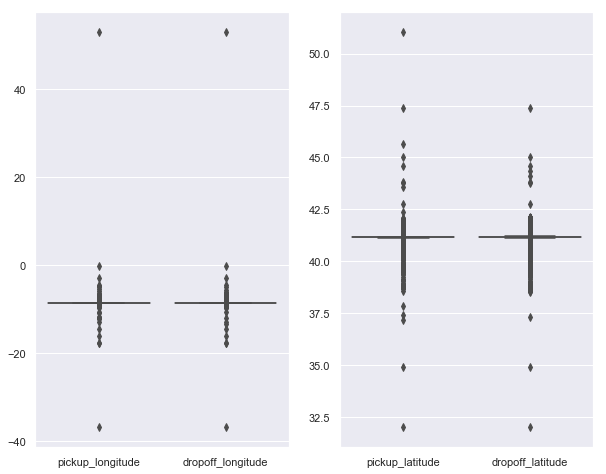

In [7]:
#. Visualize pickup and dropoff locations in sns boxplot
fig=plt.figure(figsize=(10, 8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    plt.subplot(1,2,i+1)
    sns.boxplot(data=data_train,order=loc);#plt.title(loc)

In [8]:
#.  Visualize pickup and dropoff locations in a map
import folium
basemap = folium.Map(location=[41.154489,-8.618643],tiles='OpenStreetMap',zoom_start=12)
for each in data_train[:500].iterrows():
    folium.CircleMarker([each[1]['pickup_latitude'],each[1]['pickup_longitude']],
                        radius=3,
                        color='blue',
                        popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(basemap)
    folium.CircleMarker([each[1]['dropoff_latitude'],each[1]['dropoff_longitude']],
                        radius=3,
                        color='red',
                        popup=str(each[1]['dropoff_latitude'])+','+str(each[1]['dropoff_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(basemap)
basemap

In [108]:
#. Extracting and visualize these anomalous trips
#. Add a column to indicate whether a certain trip is anomalous or not
anomaly_cols = np.array([0]*len(data_train))
anomaly_cols[data_train.pickup_longitude<-8.7174]=1
anomaly_cols[data_train.pickup_longitude>-8.486811]=1
anomaly_cols[data_train.dropoff_longitude<-8.7174]=1
anomaly_cols[data_train.dropoff_longitude>-8.486811]=1

anomaly_cols[data_train.pickup_latitude>41.2677]=1
anomaly_cols[data_train.pickup_latitude<41.105439]=1
anomaly_cols[data_train.dropoff_latitude>41.2677]=1
anomaly_cols[data_train.dropoff_latitude<41.105439]=1
print('There are total %d entries of ouliers'% sum(anomaly_cols))

#data_train.assign(anomaly = anomaly_cols)
#trj_list = [[(lat,log) for log,lat in trip] for trip in data_train.POLYLINE if len(trip)>25]
trj_list = [[[lat,log] for log,lat in trip] for trip in data_train.POLYLINE]

print(len(anomaly_cols))
print(len(trj_list))

There are total 23105 entries of ouliers
1705231
1705231


In [131]:
from keras.preprocessing.sequence import pad_sequences
trj_length = 50
n_features = 2
trj_list = pad_sequences(trj_list, maxlen = trj_length, dtype='float32', padding='pre')
trj_array = np.array(trj_list)
trj_array = trj_array.reshape(trj_array.shape[0],trj_length,n_features)
anomaly_array = np.array(anomaly_cols)
#anomaly_array = anomaly_array.reshape(anomaly_array.shape[0],1)

In [132]:
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

X_train, X_test, y_train, y_test = train_test_split(trj_array, anomaly_array, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [133]:
#. Standardize the input data, not the two features (lat, log) are in different scale already
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [136]:
#. Standardize the data
from sklearn.preprocessing import StandardScaler
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [140]:
#. Fit the LSTM model
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
epochs = 200
batch = 64
lr = 0.0001

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, input_shape=(trj_length, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, return_sequences=False))
lstm_autoencoder.add(RepeatVector(trj_length))
# Decoder
lstm_autoencoder.add(LSTM(16, return_sequences=True))
lstm_autoencoder.add(LSTM(32, return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 32)            4480      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 16)            2112      
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 2)             66        
Total params: 16,066
Trainable params: 16,066
Non-trainable params: 0
_________________________________________________________________


In [142]:
#adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer='adam')
lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled[:1000], X_train_y0_scaled[:1000], 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1076594 samples, validate on 269162 samples
Epoch 1/200







KeyboardInterrupt: 

In [85]:
#. Extract the length of GPS trajectories in trips and illustarte it using boxplot
length_list_y0 = np.array([0]*len(X_train_y0))
length_list_y1 = np.array([0]*len(X_train_y1))

for trip_y0 in X_train_y0:
    trip_len = len(trip_y0)
    length_list_y0.append(trip_len)

for trip_y1 in X_train_y1:
    trip_len = len(trip_y1)
    length_list_y1.append(trip_len)
    

plt.boxplot(length_list_y0)
plt.show()
    

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [111]:
from keras.preprocessing.sequence import pad_sequences
X_train_y0 = pad_sequences(X_train_y0, maxlen = 50, dtype='float32', padding='pre')
X_train_y1 = pad_sequences(X_train_y1, maxlen = 50, dtype='float32', padding='pre')
X_valid_y0 = pad_sequences(X_valid_y0, maxlen = 50, dtype='float32', padding='pre')
X_valid_y1 = pad_sequences(X_valid_y1, maxlen = 50, dtype='float32', padding='pre')
X_test = pad_sequences(X_test, maxlen = 50, dtype='float32', padding='pre')

In [112]:
#. Standardize the data
trj_length = 50
n_features = 2
X_train = X_train.reshape(X_train.shape[0], trj_length, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], trj_length, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], trj_length, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], trj_length, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], trj_length, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], trj_length, n_features)
X_test = X_test.reshape(X_test.shape[0], trj_length, n_features)

ValueError: cannot reshape array of size 1091347 into shape (1091347,50,2)

In [117]:
#  Establish LSTM models for training
type(X_train[1][0])
type(X_train)

numpy.ndarray